# __This is a notebook of a PyTorch skin cancer classification with ResNet50!__ 
# Project by __[Nikita Bezukhov](https://github.com/NikitaBezukhov)__!
### The data set is __[Skin Cancer MNIST: HAM10000 from Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)__.
### Was built in __[Google Colab](https://colab.research.google.com/)__ environment, so make any adjustments needed for it to work on your machine.

####
####
## __1. First lets install, import and define all necessary libraries/classes/functions that we will be using.__

In [ ]:
pip install barbar pytorch-ignite

In [2]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/skin_models/skinmodel50.pt') 
        self.val_loss_min = val_loss

In [ ]:
def split_data(source, training, validation, split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]

    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)

## __2. Data preparation.__
### Dataset consists of 7 classes of skin neoplasms that will be abbreviated as: Melanoma (MEL), Melanocytic nevi (NV), Basal cell carcinoma (BCC),  Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC), Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL), Dermatofibroma (DF), Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC)
###  Since the dataset on kaggle was clunky I predownloaded it, put all images in one folder, archived it together with Data info cvs file and uploaded to my Google disk to use from there. 
### So now we unzip it and prepare folders for data split. 

In [ ]:
!unzip /content/drive/MyDrive/Skin.zip -d /content

In [ ]:
os.mkdir('/content/orig/')
os.mkdir('/content/orig/0.MEL/')
os.mkdir('/content/orig/1.NV/')
os.mkdir('/content/orig/2.BCC/')
os.mkdir('/content/orig/3.AKIEC/')
os.mkdir('/content/orig/4.BKL/')
os.mkdir('/content/orig/5.DF/')
os.mkdir('/content/orig/6.VASC/')

os.mkdir('/content/skin/')
os.mkdir('/content/skin/training/')
os.mkdir('/content/skin/validation/')
os.mkdir('/content/skin/training/0.MEL/')
os.mkdir('/content/skin/training/1.NV/')
os.mkdir('/content/skin/training/2.BCC/')
os.mkdir('/content/skin/training/3.AKIEC/')
os.mkdir('/content/skin/training/4.BKL/')
os.mkdir('/content/skin/training/5.DF/')
os.mkdir('/content/skin/training/6.VASC/')
os.mkdir('/content/skin/validation/0.MEL/')
os.mkdir('/content/skin/validation/1.NV/')
os.mkdir('/content/skin/validation/2.BCC/')
os.mkdir('/content/skin/validation/3.AKIEC/')
os.mkdir('/content/skin/validation/4.BKL/')
os.mkdir('/content/skin/validation/5.DF/')
os.mkdir('/content/skin/validation/6.VASC/')

In [5]:
orig_all = '/content/HAM10000/'
source_MEL = '/content/orig/0.MEL/'
source_NV = '/content/orig/1.NV/'
source_BCC = '/content/orig/2.BCC/'
source_AKIEC = '/content/orig/3.AKIEC/'
source_BKL = '/content/orig/4.BKL/'
source_DF = '/content/orig/5.DF/'
source_VASC = '/content/orig/6.VASC/'

training_MEL = '/content/skin/training/0.MEL/'
training_NV = '/content/skin/training/1.NV/'
training_BCC = '/content/skin/training/2.BCC/'
training_AKIEC = '/content/skin/training/3.AKIEC/'
training_BKL = '/content/skin/training/4.BKL/'
training_DF = '/content/skin/training/5.DF/'
training_VASC = '/content/skin/training/6.VASC/'
validation_MEL = '/content/skin/validation/0.MEL/'
validation_NV = '/content/skin/validation/1.NV/'
validation_BCC = '/content/skin/validation/2.BCC/'
validation_AKIEC = '/content/skin/validation/3.AKIEC/'
validation_BKL = '/content/skin/validation/4.BKL/'
validation_DF = '/content/skin/validation/5.DF/'
validation_VASC = '/content/skin/validation/6.VASC/'

##
### Dataset has some photos of the same skin neoplasms but slightly rescaled.  
### Neoplasms are identified by lesion_id.   
###  We will read into the csv file with info about dataset and drop all duplicate photos by lesion_id to make all our photos iid (independant and identically distributed), so that we wont overfit and wont randomly put duplicate photos into validation set, othervise validation metrics would be useless. 

In [ ]:
data = pd.read_csv(r'/content/HAM10000_metadata.csv')

In [ ]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [ ]:
len(data)

10015

In [ ]:
data = data.drop_duplicates(subset='lesion_id')

In [ ]:
len(data)

7470

##
###  Now using list comprehensions we will save all image names and their diagnosis in variables, and using for loop we will sort and copy all files by their diagnosis into the corresponding folders.
### Then we will split each individual class of photos into train and val datasets 80/20%.

In [ ]:
image_names = [x for x in data['image_id']]
diagnosis = [x for x in data['dx']]

In [ ]:
print(len(image_names))
print(len(diagnosis))

7470
7470


In [ ]:
print(image_names[0])
print(diagnosis[0])

ISIC_0027419
bkl


In [ ]:
print(type(image_names[0]))
print(type(diagnosis[0]))


<class 'str'>
<class 'str'>


In [ ]:
pd.unique(data['dx'])

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
for index, image in enumerate(image_names):
    image = image + '.jpg'
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(orig_all, image), os.path.join(source_MEL, image))
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(orig_all, image), os.path.join(source_NV, image))
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_BCC, image))
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_AKIEC, image))
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(orig_all, image), os.path.join(source_BKL, image))
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(orig_all, image), os.path.join(source_DF, image))
    elif diagnosis[index] == 'vasc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_VASC, image))            

In [ ]:
# Print amount of pictures for each class
print(len(os.listdir(source_MEL)))
print(len(os.listdir(source_NV)))
print(len(os.listdir(source_BCC)))
print(len(os.listdir(source_AKIEC)))
print(len(os.listdir(source_BKL)))
print(len(os.listdir(source_DF)))
print(len(os.listdir(source_VASC)))

614
5403
327
228
727
73
98


In [ ]:
split_size = 0.8
split_data(source_MEL, training_MEL, validation_MEL, split_size)
split_data(source_NV, training_NV, validation_NV, split_size)
split_data(source_BCC, training_BCC, validation_BCC, split_size)
split_data(source_AKIEC, training_AKIEC, validation_AKIEC, split_size)
split_data(source_BKL, training_BKL, validation_BKL, split_size)
split_data(source_DF, training_DF, validation_DF, split_size)
split_data(source_VASC, training_VASC, validation_VASC, split_size)

In [ ]:
# Print amount of pictures for each class after split, train/val.
print(len(os.listdir(training_MEL)))
print(len(os.listdir(validation_MEL)))
print(len(os.listdir(training_NV)))
print(len(os.listdir(validation_NV)))
print(len(os.listdir(training_BCC)))
print(len(os.listdir(validation_BCC)))
print(len(os.listdir(training_AKIEC)))
print(len(os.listdir(validation_AKIEC)))
print(len(os.listdir(training_BKL)))
print(len(os.listdir(validation_BKL)))
print(len(os.listdir(training_DF)))
print(len(os.listdir(validation_DF)))
print(len(os.listdir(training_VASC)))
print(len(os.listdir(validation_VASC)))

491
123
4322
1081
261
66
182
46
581
146
58
15
78
20


### Even though dataset is greatly skewed, during project development I tried to train model with class weights, but I got worse results than with straight up imbalanced training. 
### I came to conclusion that inherent regularization of ResNet50 due to Bottleneck layers and Batch normalization together with weight decay and random data augmentations is enough to prevent model from overfitting even on this imbalanced of a dataset.

In [6]:
traindir = r'/content/skin/training/'
valdir = r'/content/skin/validation/'

##
## __3. Data augmentation.__
### Dataset consists of 7470 unique skin neoplasm photos with height=450 and width=600 pixels.
### By examining the pictures I noticed that in overwhelming majority off them the skin neoplasm is centerd and lies in the center 450x450 crop of the picture (with little exceptions).
### So I believe that there is no reason to squeeze photos on width axis (and lose valuable information) during resize, since our object of interest is almost always in the center crop. We will squueze photos only a little bit to better capture objects that cant fit in 450x450 crop.
### Since we are using ResNet50, to get to 224x224 size, we will first resize to 224x280 (6.25% squeeze on width) and then center crop 224x224 piece.
### Other beneficial transformations could be Random rotation and Horizontal/Vertical flipping. Since skin neoplasms can be in a lot of different shapes, by rotating and horizontally flipping them we will still get skin neoplasms that we would expect our model to classify correctly. These two transformations will help our model greatly. They will inflate our dataset, increase model robustness (especially since we have some classes with very small representation), help with better generalization and overfitting prevention.
### And because we will be using pretrained ResNet50 ImageNet weights to start with, we will use ImageNet style normalization.
### Batch size will be 64.

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

In [ ]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

##
## __4. Training.__
### Next we define model, change final layer to a 7 way linear classifier, choose Cross Entropy loss function, Adam optimizer (with 0.0001 weight decay), define TensorBoard writer, and since we will be using early stopping, the epoch number will be set to 999.

In [ ]:
device = 'cuda'

model = torchvision.models.resnet50(pretrained=True).to(device)

model.fc = nn.Linear(2048, 7).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

epochs = 999

writer = SummaryWriter(log_dir='/content/drive/MyDrive/skin_logs/', filename_suffix="skin50")

In [ ]:
# Shows info about model
summary(model, input_size=(3, 224, 224))

##
### Early stopping tracks validation loss decrease and patience was chosen to be 50. This big of a number is justified, because while developing this project I trained the model a few times and after 80-100 epochs model still slowly and steadily decreases training loss and not overfitting, but validation loss moves pretty stochastically, so not to stop too early patience was chosen to be 50 epochs.

In [ ]:
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in range(epochs):
    train_loss = 0.00
    val_loss = 0.00
    train_accuracy = Accuracy()
    val_accuracy = Accuracy()
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        train_accuracy.update((torch.round(nn.functional.softmax(outputs, dim=1)), labels))
    print(f"Train Accuracy: {train_accuracy.compute()}")
    train_loss /= len(train_loader)
    train_loss_formated = "{:.4f}".format(train_loss)

    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy.update((torch.round(nn.functional.softmax(outputs, dim=1)), labels))
    print(f"Val Accuracy: {val_accuracy.compute()}")
    val_loss /= len(val_loader)
    val_loss_formated = "{:.4f}".format(val_loss)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)
    writer.add_scalar('Accuracy/train', train_accuracy.compute(), epoch+1)
    writer.add_scalar('Accuracy/val', val_accuracy.compute(), epoch+1)

    # Early Stopping
    early_stopping(val_loss, model)       
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/skinmodel50.pt'))    

##
## __5. Results.__
### Model stopped training after 290 epochs (around 11-12 hours on 1 Tesla P100 GPU) with Early stopping point at 240 epochs. 
### Result metrics are:
#### Train Accuracy: 0.9715385903231207
#### Val Accuracy: 0.9846359385437542
#### Training Loss: 0.0814
#### Validation Loss: 0.0366
####
### Now we will look at confusion matrix and classification report with Precision, Recall, F1 score and AUC for each class.

              precision    recall  f1-score   support

         MEL       0.94      0.98      0.96       123
          NV       0.99      0.99      0.99      1081
         BCC       1.00      0.97      0.98        66
       AKIEC       0.98      0.93      0.96        46
         BKL       0.97      0.97      0.97       146
          DF       1.00      1.00      1.00        15
        VASC       1.00      1.00      1.00        20

    accuracy                           0.99      1497
   macro avg       0.98      0.98      0.98      1497
weighted avg       0.99      0.99      0.99      1497

AUC of class MEL = 0.9996153891669921
AUC of class NV = 0.9989504020493845
AUC of class BCC = 0.9999576477563898
AUC of class AKIEC = 0.9997003565756749
AUC of class BKL = 0.9993662735872971
AUC of class DF = 1.0
AUC of class VASC = 1.0


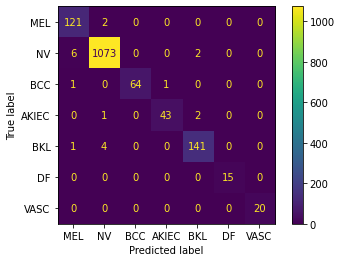

In [60]:
num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        model.eval()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,torch.sigmoid(outputs).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
print(classification_report(lbllist, predlist, target_names=target_names))
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

##
### For better validation robustness lets spin validation dataset 5 times with random rotations and horizontal flip and then check our metrics again.

In [78]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

              precision    recall  f1-score   support

         MEL       0.91      0.98      0.94       615
          NV       0.99      0.99      0.99      5405
         BCC       1.00      0.98      0.99       330
       AKIEC       1.00      0.92      0.95       230
         BKL       0.96      0.97      0.96       730
          DF       0.97      1.00      0.99        75
        VASC       0.99      1.00      1.00       100

    accuracy                           0.98      7485
   macro avg       0.97      0.98      0.97      7485
weighted avg       0.98      0.98      0.98      7485

AUC of class MEL = 0.9987474704441368
AUC of class NV = 0.9982364530705188
AUC of class BCC = 0.9999500243525401
AUC of class AKIEC = 0.9996817786833668
AUC of class BKL = 0.9992403394745648
AUC of class DF = 0.9999712100764733
AUC of class VASC = 0.9999945836154368


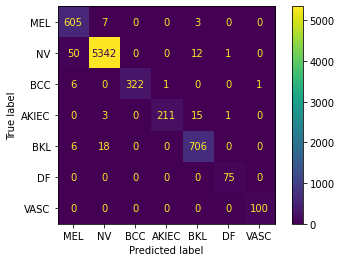

In [79]:
num_classes = 7

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
for n in range(5):
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(val_loader):
            model.eval()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,torch.sigmoid(outputs).cpu()])
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy() 

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
print(classification_report(lbllist, predlist, target_names=target_names))
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

## In the end we were able to achieve 97% average F1 score with all by class AUCs close to 100%! 
## And what is interesting, even on 2 classes with smallest representations (only 78 and 58 training images) we still were able to achieve 100 and 99% F1 score respectively.
## I believe that the most important reason for that good of a result were well chosen data augmentations that helped not only to enrich our dataset, but also prevent overfitting. 